In [1]:
import h5py
import numpy as np
from numpy import linalg
import os
import matplotlib.pyplot as plt
import mat73
from collections import namedtuple
from scipy.signal import butter, sosfiltfilt
from scipy.signal import stft
from scipy.signal import ShortTimeFFT
from scipy.signal import butter
from mne.decoding import CSP
from scipy import stats
import mne
from sklearn.covariance import MinCovDet

In [2]:
import seaborn as sns
import copy
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
import scipy.linalg as la

In [3]:
def get_eeg(filename):
    with h5py.File(filename) as h5f:
        print(h5f['eeg'].keys())
        return h5f['eeg/data'][:-1, :]

In [4]:
raw_data_folder = r'..\data\raw'
filename = 'mulines_OVERTexample.h5'
filename_full = os.path.join(raw_data_folder, filename)
eeg_1 = get_eeg(filename_full)
filename = 'mulines_NOMOVexample.h5'
filename_full = os.path.join(raw_data_folder, filename)
eeg_2 = get_eeg(filename_full)

<KeysViewHDF5 ['blocks', 'data', 'streamInfo']>
<KeysViewHDF5 ['blocks', 'data', 'streamInfo']>


In [112]:
def change_trigger(eeg):
    photo_orig = eeg[:, -1]

    photo = np.zeros(len(photo_orig))
    photo[np.where(photo_orig == np.min(photo_orig))] = 1
    photo = photo.astype(int)
    return np.concatenate([eeg[:, :-1], photo.reshape((-1, 1))], axis=1)

eeg_1 = change_trigger(eeg_1)
eeg_2 = change_trigger(eeg_2)

In [113]:
# частотный фильтр
sos = butter(N=4, Wn=(6, 35), btype='bandpass', output='sos', fs=1000)
eeg_f1 = sosfiltfilt(np.ascontiguousarray(sos), eeg_1[:, :-1] * (10**6), axis=0)
eeg_f2 = sosfiltfilt(np.ascontiguousarray(sos), eeg_2[:, :-1] * (10**6), axis=0)

In [114]:
# эпохи
def get_epochs(eeg, trigger, epoch_width=3000):
    events_ind = np.where(np.diff(trigger) == 1)[0]
    epochs_ind = events_ind.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind), 1)) 
    epochs = np.array([eeg[x] for x in epochs_ind])
    return epochs

epochs_1 = get_epochs(eeg_f1, eeg_1[:, -1])
epochs_2 = get_epochs(eeg_f2, eeg_2[:, -1])
epochs_1.shape

(100, 3000, 64)

# calculate csp

In [115]:
filename = r'C:\Users\hodor\Documents\Quasi\quasi-clf\data\covariance_matrixes\AnatolyExample.h5'
with h5py.File(filename, 'r') as h5f:
    c1 = h5f['overt'][:]
    c2 = h5f['nomove'][:]

In [450]:
def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    # U, l, _ = linalg.svd(sigma)
    # return U.dot( np.diag(l ** -0.5) )
    [u, s, vh] = np.linalg.svd(sigma)
    epsilon = 1e-5
            
    # ZCA Whitening matrix: U * Lambda * U'
    x = np.dot(u, np.dot(np.diag(1.0/np.sqrt(s + epsilon)), u.T))
    # eigenvalue decomposition of the covariance matrix
    
    # d, V = np.linalg.eigh(sigma)
    # fudge = 10E-18
    
    # # A fudge factor can be used so that eigenvectors associated with small eigenvalues do not get overamplified.
    # D = np.diag(1. / np.sqrt(d+fudge))
    
    # # whitening matrix
    # x = np.dot(np.dot(V, D), V.T)
    return x

def csp(c1, c2):
    P = whitening(c1+c2)
    # The mean covariance matrices may now be transformed
    cov_1_white = np.dot(P, np.dot(c1, np.transpose(P)))
    cov_2_white = np.dot(P, np.dot(c2, np.transpose(P)))
    # Since CSP requires the eigenvalues and eigenvector be sorted in descending order we find and sort the generalized eigenvalues and eigenvector
    E, U = la.eig(cov_1_white, cov_2_white)
    order = np.argsort(E)
    order = order[::-1]
    E = E[order]
    U = U[:, order]
    
    # The projection matrix (the spatial filter) may now be obtained
    W = np.dot(np.transpose(U), P)
    return W
    # B, _, _ = linalg.svd( P.T.dot(c2).dot(P) )
    # W = P.dot(B)

    # maxinds = np.array([np.where(np.abs(W[:, i]) == np.max(np.abs(W[:, i])))[0][0] for i in range(W.shape[1])])
    # max_magnitudes = np.array([W[maxinds[i], i] for i in range(W.shape[1])])
    # rowsign = np.sign(max_magnitudes)
    # W_fixed = W * rowsign
    # return W_fixed

def apply_csp(eeg, W):
    return eeg @ W

In [527]:
def csp(c1, c2):
    R1 = c1 / np.trace(c1)
    R2 = c2 / np.trace(c2)
    L, W = la.eig(R1, R1+R2)
    order = np.argsort(L)
    L = L[order]
    W = W[:, order]
    maxinds = np.array([np.where(np.abs(W[:, i]) == np.max(np.abs(W[:, i])))[0][0] for i in range(W.shape[1])])
    max_magnitudes = np.array([W[maxinds[i], i] for i in range(W.shape[1])])
    rowsign = np.sign(max_magnitudes)
    W_fixed = W * rowsign
    projForward = la.pinv(W_fixed).T
    evals = L
    return W_fixed, projForward, evals

In [522]:
type(c1[0, 0])

numpy.float64

In [532]:
spatialW, projForward, evals = csp(c1, c2)

In [3]:
filename = r'..\data\test_robustcov_csp_RESPONSE.h5'
with h5py.File(filename, 'r') as h5f:
    print(h5f['data'].keys())
    cov2 = h5f['data/cov0'][:]
    cov1 = h5f['data/cov1'][:]
    projInverse = h5f['data/projInverse'][:]
    projForward = h5f['data/projForward'][:]

<KeysViewHDF5 ['cov0', 'outliers0', 'cov1', 'outliers1', 'projInverse', 'projForward', 'evals']>


<Axes: >

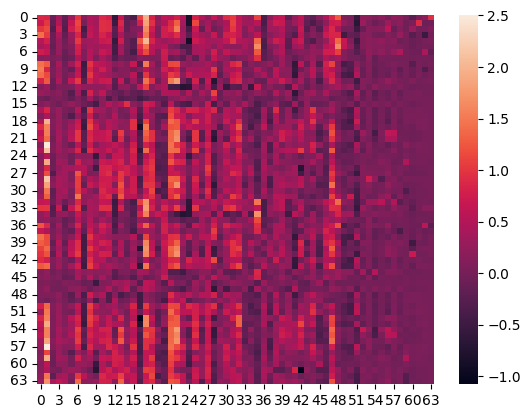

In [6]:
sns.heatmap(projForward)

In [531]:
spatialW, projForward, evals = csp(cov1, cov2)
filename = r'..\data\test_CSP.h5'
with h5py.File(filename, 'w') as h5f:
    h5f.create_dataset('projInverse', data=spatialW)
    h5f.create_dataset('projForward', data=projForward)
    h5f.create_dataset('evals', data=evals)

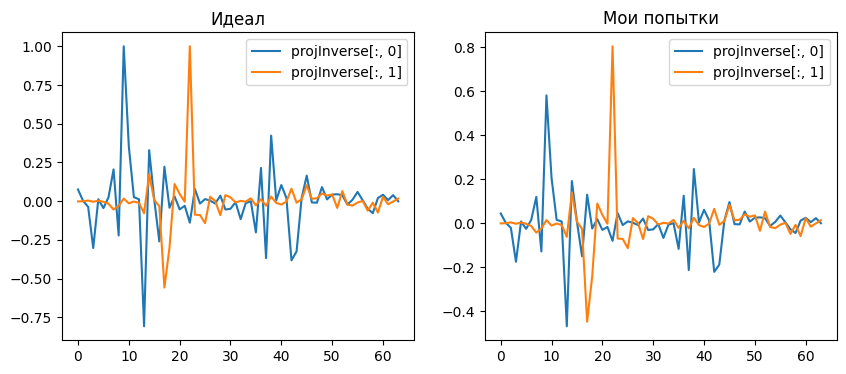

In [526]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(projInverse[:, [0, 1]], label=['projInverse[:, 0]','projInverse[:, 1]'])
plt.title('Идеал')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(spatialW[:, [0, 1]], label=['projInverse[:, 0]','projInverse[:, 1]'])
plt.title('Мои попытки')
plt.legend()

In [518]:
coef = projInverse[:, [0, 1]] / spatialW[:, [0, 1]]

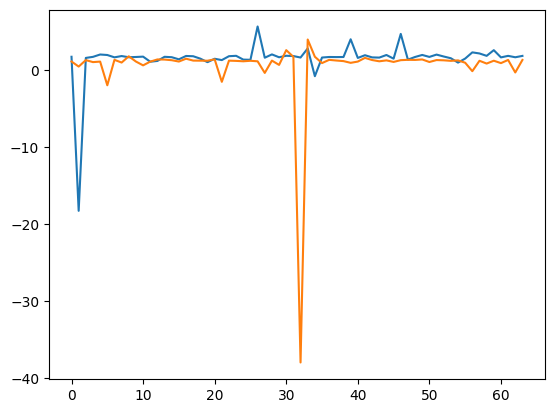

In [517]:
plt.plot(coef)

Text(0.5, 1.0, 'Мои попытки')

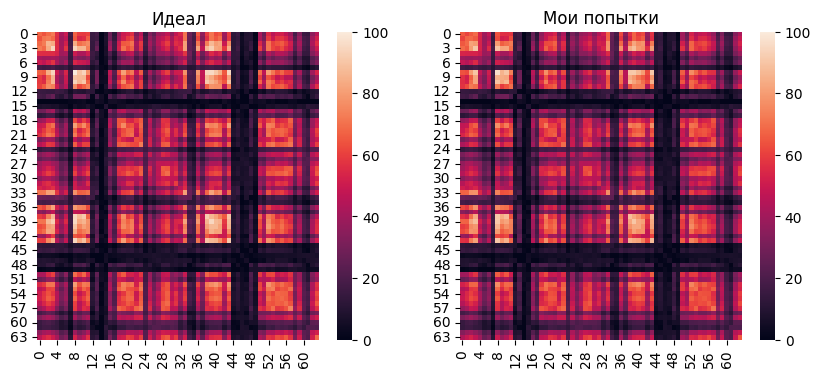

In [493]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cov2, vmin=0, vmax=100)
plt.title('Идеал')
plt.subplot(1, 2, 2)
sns.heatmap(c2, vmin=0, vmax=100)
plt.title('Мои попытки')

In [533]:
eeg_csp_1 = apply_csp(eeg_f1, spatialW)
eeg_csp_2 = apply_csp(eeg_f2, spatialW)
# eeg_csp_1 = apply_csp(eeg_f1, projInverse)
# eeg_csp_2 = apply_csp(eeg_f2, projInverse)

In [534]:
def get_fft(eeg):
    SFT = ShortTimeFFT(win=np.ones(1000), hop=100, fs=1000,  fft_mode='onesided' )
    fft_res = np.abs(SFT.stft(eeg, axis=0)) ** 2
    fft_t = SFT.t(len(eeg))
    return fft_res, fft_t

In [535]:
fft_res_1, fft_t_1 = get_fft(eeg_csp_1)
fft_res_2, fft_t_2 = get_fft(eeg_csp_2)

In [536]:
def find_events(trigger): 
    return np.where(np.diff(trigger) == 1)[0]

events_ind_1 = find_events(eeg_1[:, -1])
events_ind_2 = find_events(eeg_2[:, -1])

epoch_width = 2500
epochs_ind_1 = events_ind_1.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind_1), 1)) 
epochs_ind_2 = events_ind_2.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind_2), 1))

# smart algorithm

In [537]:
def combine_all_epoch(fft_res, fft_t, epochs_ind):
    ind = (fft_t * 1000).astype(int)
    fft_t_ind = [np.where(np.isin(ind, X))[0] for X in epochs_ind]
    fft_all = []
    for ind in fft_t_ind:
        fft_epoch = fft_res[:41, :, ind].T
        fft_all.extend(fft_epoch)
    fft_all = np.array(fft_all)
    return fft_all

In [538]:
fft_res_all_1 = combine_all_epoch(fft_res_1, fft_t_1, epochs_ind_1)
fft_res_all_2 = combine_all_epoch(fft_res_2, fft_t_2, epochs_ind_2)

In [539]:
fft_res_all_1.shape

(2500, 64, 41)

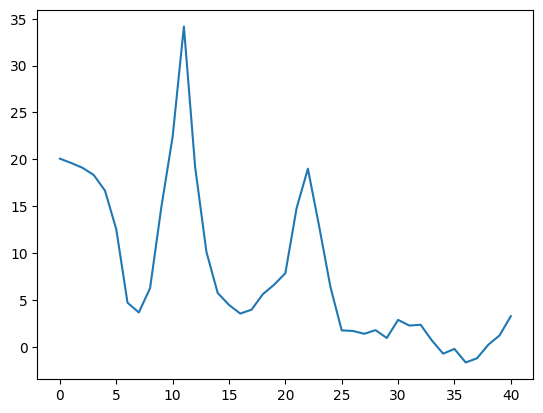

In [596]:
fft_log_1 = np.mean(10 * np.log(fft_res_all_1[:, 0]), axis=0)
fft_log_2 = np.mean(10 * np.log(fft_res_all_2[:, 0]), axis=0)
plt.plot(fft_log_2 - fft_log_1)

In [579]:
np.log(fft_res_all_1[:, 1]).shape

(2500, 41)

In [ ]:
from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal
    
    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.  
    freqs : list of floats
        Yhe frequencies for which the PSD was computed (useful for plotting later)
    '''
    nchannels = 64
    ntrials = trials.shape[0]
    nsamples = 3000
    sample_rate = 1000
    trials_PSD = np.zeros((nchannels, 1501, ntrials))

    # Iterate over trials and channels
    for ch in range(nchannels):
        # Calculate the PSD
        (PSD, freqs) = mlab.psd(trials[:, :, ch], NFFT=int(nsamples), Fs=sample_rate)
        trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs

In [589]:
def histogram_intersection(hist1, hist2):
    sign = 1 if np.nanmedian(hist1) - np.nanmedian(hist2) > 0 else -1
    intersection = np.sum(np.minimum(hist1, hist2))
    area = 1- (intersection) / (np.sum(hist1) + np.sum(hist2) - intersection) 
    return sign * area * 100#(100 - intersection / (area/2) * 100)

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def calculate_intersections(fft_res_all_1, fft_res_all_2):
    freqs = []
    for ch in range(fft_res_all_1.shape[1]):
        channels = []
        for fr in range(fft_res_all_1.shape[2]):
            curr_1 = 10 * np.log(normalize(fft_res_all_1[:, ch, fr]))
            curr_2 = 10 * np.log(normalize(fft_res_all_2[:, ch, fr]))
            curr_1 = curr_1[np.where(np.isfinite(curr_1))]
            curr_2 = curr_2[np.where(np.isfinite(curr_2))]
            estimated_pdf_1 = stats.gaussian_kde(curr_1).evaluate(np.linspace(np.nanmin(curr_1), np.nanmax(curr_1), 100))
            estimated_pdf_2 = stats.gaussian_kde(curr_2).evaluate(np.linspace(np.nanmin(curr_2), np.nanmax(curr_2), 100))
            intersection = histogram_intersection(estimated_pdf_1, estimated_pdf_2)
            # hist1, _ = np.histogram(curr_1, bins=100, density=True)
            # hist2, _ = np.histogram(curr_2, bins=100, density=True)
            # intersection = histogram_intersection(hist1, hist2)
            channels.append(intersection)
        freqs.append(channels)
    return np.array(freqs)

In [590]:
# intersection_matrix2 = calculate_intersections(fft_res_all_1, fft_res_all_2)
intersection_matrix3 = calculate_intersections(fft_res_all_1, fft_res_all_2)

C:\Users\hodor\AppData\Local\Temp\ipykernel_9596\623163951.py:21: RuntimeWarning: divide by zero encountered in log
  curr_1 = 10 * np.log(normalize(fft_res_all_1[:, ch, fr]))
C:\Users\hodor\AppData\Local\Temp\ipykernel_9596\623163951.py:22: RuntimeWarning: divide by zero encountered in log
  curr_2 = 10 * np.log(normalize(fft_res_all_2[:, ch, fr]))


Text(0.5, 36.72222222222221, 'frequencies')

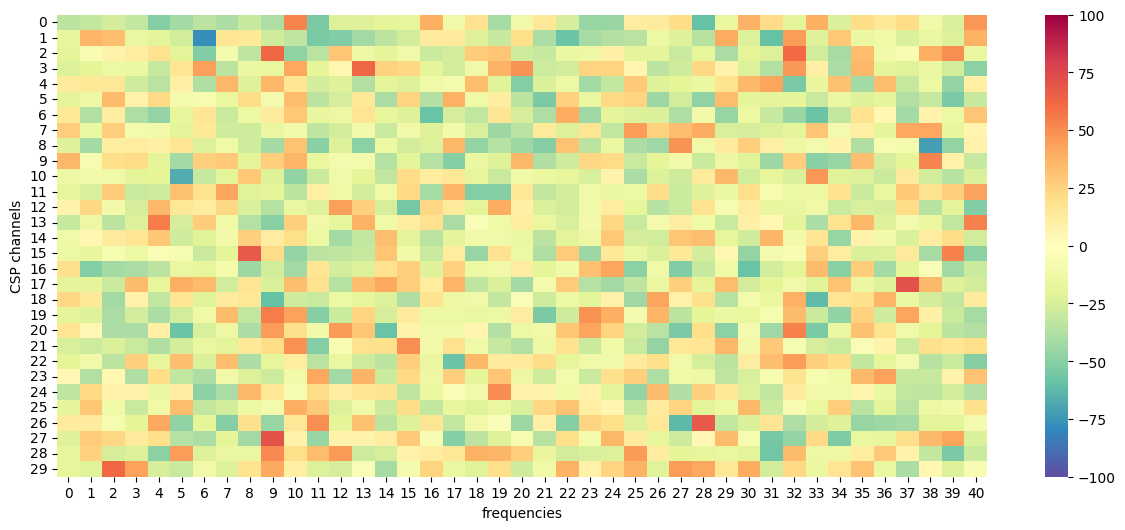

In [591]:
plt.figure(figsize=(15, 6))
# sns.heatmap(intersection_matrix2, vmin=-np.max(intersection_matrix2), vmax=np.max(intersection_matrix2), cmap='Spectral')
sns.heatmap(intersection_matrix3[:30] , vmin=-100, vmax=100, cmap='Spectral_r')
plt.ylabel('CSP channels')
plt.xlabel('frequencies')

C:\Users\hodor\AppData\Local\Temp\ipykernel_9596\21652770.py:13: RuntimeWarning: divide by zero encountered in log
  curr_1 = 10 * np.log(curr_1)
C:\Users\hodor\AppData\Local\Temp\ipykernel_9596\21652770.py:14: RuntimeWarning: divide by zero encountered in log
  curr_2 = 10 * np.log(curr_2)


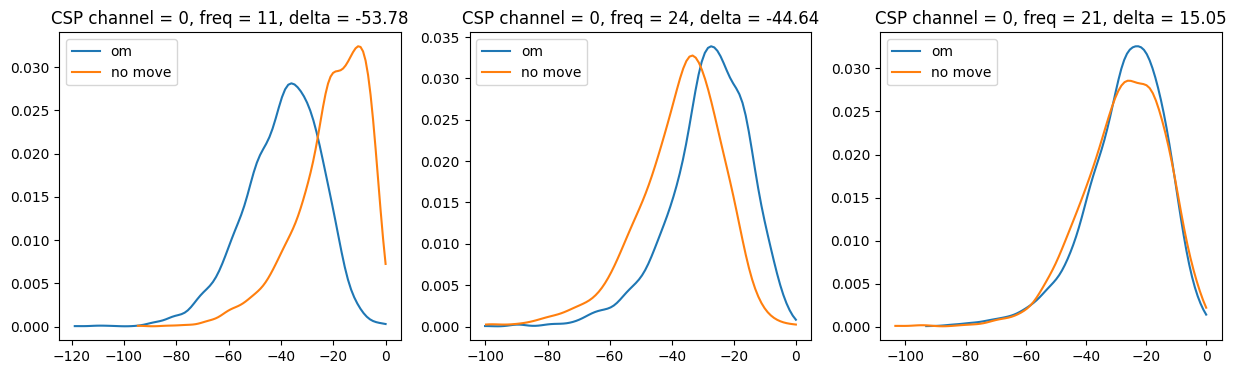

In [588]:
sel = [(0, 11), (0, 24), (0, 21)]

def histogram_intersection(hist1, hist2):
    sign = 1 if np.nanmedian(hist1) - np.nanmedian(hist2) > 0 else -1
    intersection = np.sum(np.minimum(hist1, hist2))
    area = 1- (intersection) / (np.sum(hist1) + np.sum(hist2) - intersection) 
    return sign * area * 100#(100 - intersection / (area/2) * 100)

plt.figure(figsize=(15, 4))
for i, pair in enumerate(sel):
    curr_1 = normalize(fft_res_all_1[:, pair[0], pair[1]])
    curr_2 = normalize(fft_res_all_2[:, pair[0], pair[1]])
    curr_1 = 10 * np.log(curr_1)
    curr_2 = 10 * np.log(curr_2)
    curr_1 = curr_1[np.where(np.isfinite(curr_1))]
    curr_2 = curr_2[np.where(np.isfinite(curr_2))]
    x1 = np.linspace(np.nanmin(curr_1), np.nanmax(curr_1), 100)
    x2 = np.linspace(np.nanmin(curr_2), np.nanmax(curr_2), 100)
    estimated_pdf_1 = stats.gaussian_kde(curr_1).evaluate(x1)
    estimated_pdf_2 = stats.gaussian_kde(curr_2).evaluate(x2)
    intersection = histogram_intersection(estimated_pdf_1, estimated_pdf_2)
    plt.subplot(1, 3, i+1)
    plt.plot(x1, estimated_pdf_1, label='om')
    plt.plot(x2, estimated_pdf_2, label='no move')
    plt.title(f'CSP channel = {pair[0]}, freq = {pair[1]}, delta = {round(intersection, 2)}')
    plt.legend()
plt.show()

In [562]:
curr_1

array([0.137267  , 0.32695267, 0.39922633, ..., 0.00675527, 0.00602892,
       0.12422784])

In [270]:
ch = 0
fr = 10
curr_1 = normalize(fft_res_all_1[:, ch, fr])
curr_2 = normalize(fft_res_all_2[:, ch, fr])
estimated_pdf_1 = stats.gaussian_kde(curr_1).evaluate(np.linspace(np.nanmin(curr_1), np.nanmax(curr_1), 1000))
estimated_pdf_2 = stats.gaussian_kde(curr_2).evaluate(np.linspace(np.nanmin(curr_2), np.nanmax(curr_2), 1000))

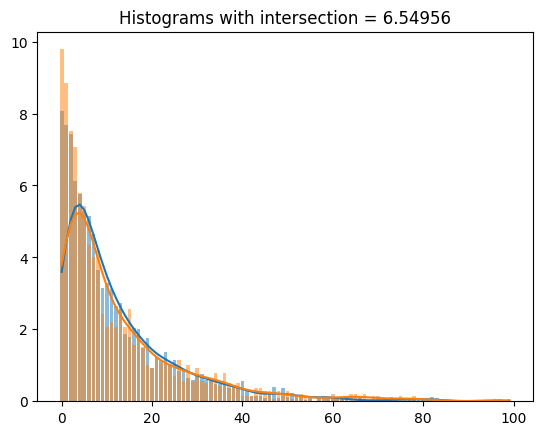

In [359]:
# def histogram_intersection(hist1, hist2):
#     sign = 1 if np.nanmedian(hist1) - np.nanmedian(hist2) > 0 else -1
#     intersection = np.sum(np.minimum(hist1, hist2))
#     area = np.sum(hist1) + np.sum(hist2)
#     print(area)
#     return sign *(100 - intersection / area * 100)

hist1, _ = np.histogram(curr_1, bins=100, density=True)
hist2, _ = np.histogram(curr_2, bins=100, density=True)
# Compute histogram intersection
intersection =  histogram_intersection(estimated_pdf_1, estimated_pdf_2)
# intersection =  histogram_intersection(hist1, hist2)

# Plot histograms
plt.bar(range(100), hist1, alpha=0.5)
plt.bar(range(100), hist2, alpha=0.5)
plt.plot(estimated_pdf_1)
plt.plot(estimated_pdf_2)
plt.title("Histograms with intersection = {:.5f}".format(intersection))
plt.show()

# psd

In [10]:
from matplotlib import mlab

def psd(trials):
    '''
    Calculates for each trial the Power Spectral Density (PSD).
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal
    
    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.  
    freqs : list of floats
        Yhe frequencies for which the PSD was computed (useful for plotting later)
    '''
    nchannels = 64
    ntrials = trials.shape[0]
    nsamples = 3000
    sample_rate = 1000
    trials_PSD = np.zeros((nchannels, 1501, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(trials[trial, :, ch], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()
                
    return trials_PSD, freqs

In [11]:
psd_om, freqs = psd(epochs_1)
psd_nomove, freqs = psd(epochs_2)
trials_PSD = {'om': psd_om, 'nomove': psd_nomove}

In [12]:
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd().
    
    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd() 
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))
    
    nchans = len(chan_ind)
    
    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)
    
    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)
    
        # Plot the PSD for each class
        for cl in trials_PSD.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)
    
        # All plot decoration below...
        
        plt.xlim(1,30)
        
        if maxy != None:
            plt.ylim(0,maxy)
    
        plt.grid()
    
        plt.xlabel('Frequency (Hz)')
        
        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()
        
    plt.tight_layout()

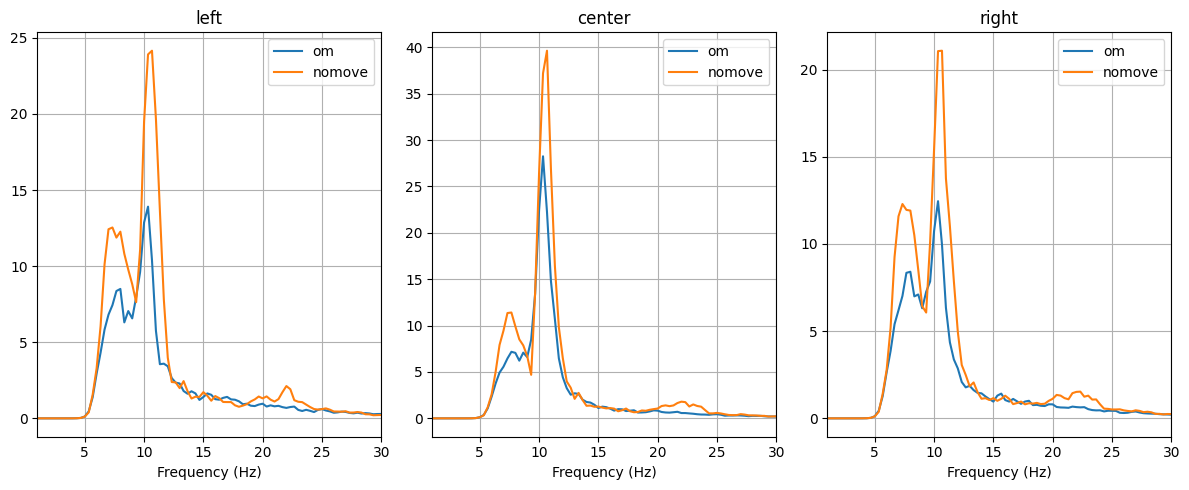

In [13]:
plot_psd(
    trials_PSD,
    freqs,
    [41, 53, 56],
    chan_lab=['left', 'center', 'right'],
    # maxy=500
)

In [14]:
def logvar(trials):
    '''
    Calculate the log-var of each channel.
    
    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.
        
    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=1))

In [15]:
# Apply the function
trials_logvar = {'om': logvar(epochs_1),
                 'nomove': logvar(epochs_2)}

In [16]:
trials_logvar['om'].shape

(100, 64)

In [17]:
cl1 = 'om'
cl2 = 'nomove'
nchannels = 64
def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 2 classes.
    '''
    plt.figure(figsize=(12,5))
    
    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=0)
    y1 = np.mean(trials[cl2], axis=0)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    # plt.legend(cl_lab)

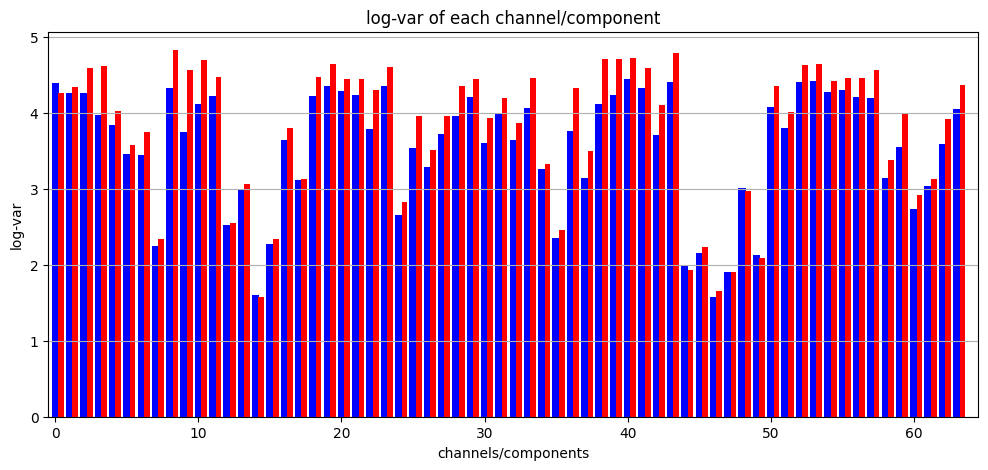

In [18]:
# Plot the log-vars
plot_logvar(trials_logvar)

## calculate robust covariance

In [378]:
epochs_1 = np.concatenate(get_epochs(eeg_f1, eeg_1[:, -1]), axis=0)
epochs_2 = np.concatenate(get_epochs(eeg_f2, eeg_2[:, -1]), axis=0)

In [380]:
filename = r'..\data\test_robustcov_csp.h5'
with h5py.File(filename, 'w') as h5f:
    h5f.create_dataset('epochs_om', data=epochs_1)
    h5f.create_dataset('epochs_nomove', data=epochs_2)

In [102]:
MCD = MinCovDet(support_fraction=0.5)
c1 = MCD.fit(epochs_1)

In [8]:
MCD = MinCovDet(support_fraction=0.5)
c2 = MCD.fit(epochs_2)

In [9]:
filename = r'C:\Users\hodor\Documents\Quasi\quasi-clf\data\covariance_matrixes\AnatolyExample.h5'
with h5py.File(filename, 'a') as h5f:
    # h5f.create_dataset('overt', data=c1.covariance_)
    h5f.create_dataset('nomove', data=c2.covariance_)

## get robust covariance

In [19]:
filename = r'C:\Users\hodor\Documents\Quasi\quasi-clf\data\covariance_matrixes\AnatolyExample.h5'
with h5py.File(filename, 'r') as h5f:
    c1 = h5f['overt'][:]
    c2 = h5f['nomove'][:]

In [20]:
nsamples = 3000

# CSP calculation

In [97]:


# def cov(trials):
#     ''' Calculate the covariance for each trial and return their average '''
#     ntrials = trials.shape[2]
#     covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
#     return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(cov_r, cov_f):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_f - Array (channels x samples x trials) containing foot movement trials
    returns:
        Mixing matrix W
    '''
    # cov_r = cov(trials_r)
    # cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)

    maxinds = np.array([np.where(np.abs(W[:, i]) == np.max(np.abs(W[:, i])))[0][0] for i in range(W.shape[1])])
    max_magnitudes = np.array([W[maxinds[i], i] for i in range(W.shape[1])])
    rowsign = np.sign(max_magnitudes)
    W_fixed = W * rowsign
    return W_fixed

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    ntrials = trials.shape[0]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[i].T)
    return trials_csp

In [93]:
P = whitening(c1 + c2)
B, _, _ = linalg.svd( P.T.dot(c2).dot(P) )
W = P.dot(B)

In [98]:
# Apply the functions
W = csp(c1, c2)
trials_csp = {cl1: apply_mix(W, epochs_1),
              cl2: apply_mix(W, epochs_2)}

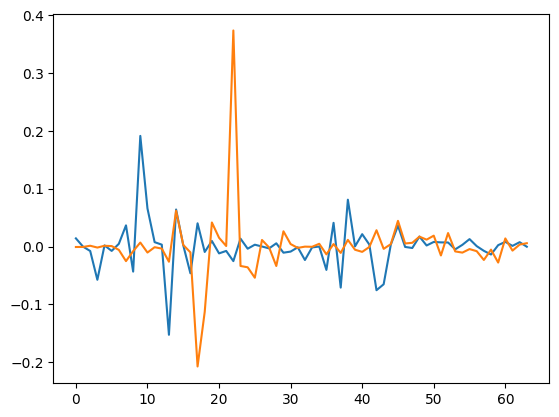

In [99]:
plt.plot(W[:, [0, 1]])

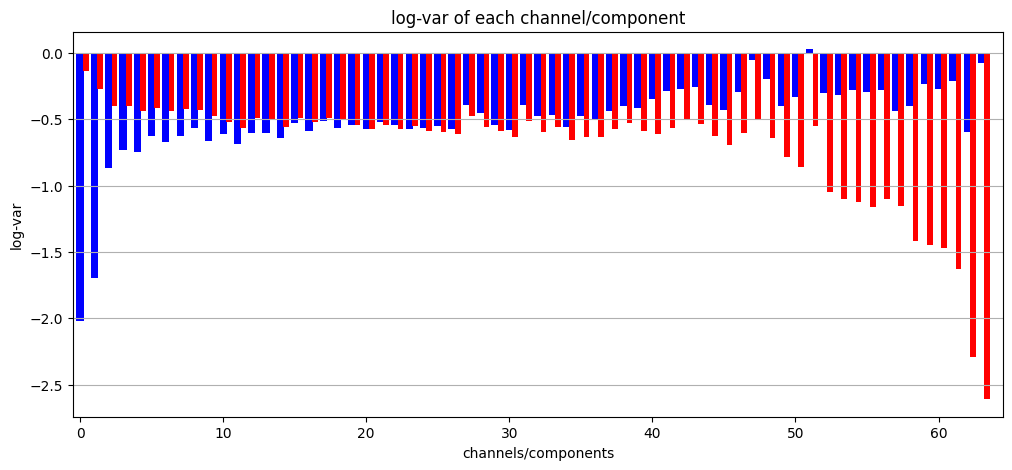

In [174]:
trials_logvar = {cl1: logvar(trials_csp[cl1].T),
                 cl2: logvar(trials_csp[cl2]).T}
plot_logvar(trials_logvar)

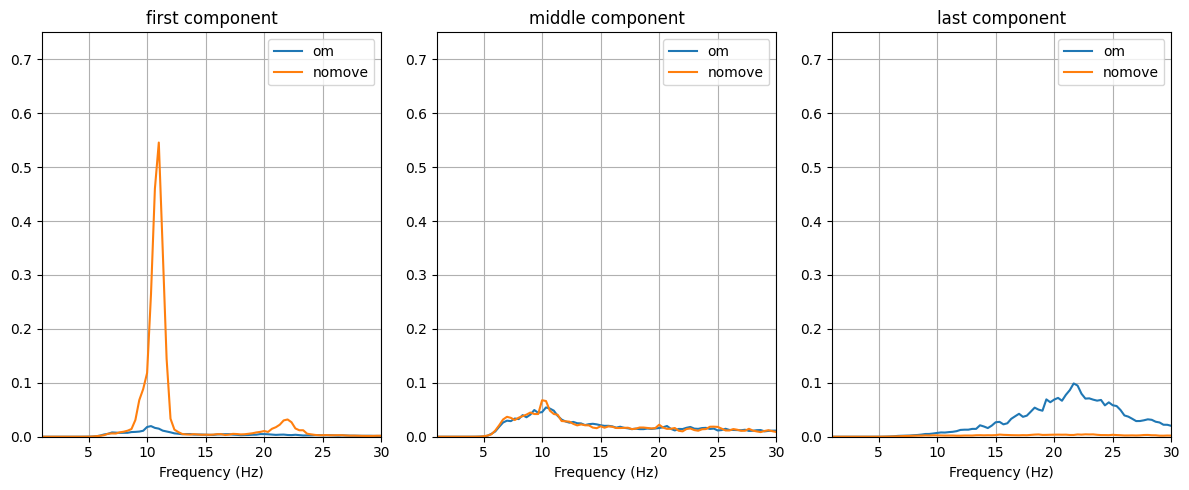

In [176]:
psd_r, freqs = psd(trials_csp[cl1].T)
psd_f, freqs = psd(trials_csp[cl2].T)
trials_PSD = {cl1: psd_r, cl2: psd_f}

plot_psd(trials_PSD, freqs, [0,28,-1], chan_lab=['first component', 'middle component', 'last component'], maxy=0.75 )

In [178]:
def plot_scatter(left, foot):
    plt.figure()
    plt.scatter(left[0,:], left[-1,:], color='b')
    plt.scatter(foot[0,:], foot[-1,:], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')

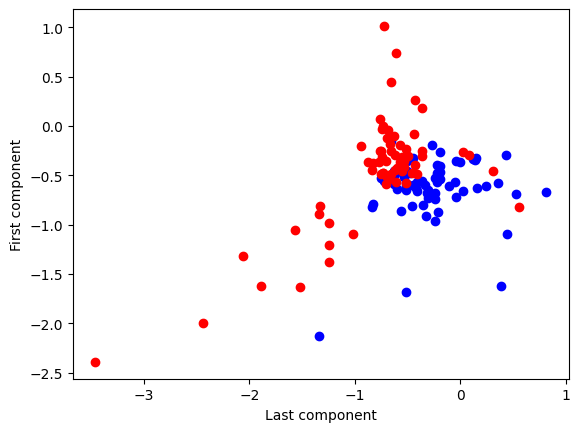

In [179]:
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

In [34]:
R1 = c1 / np.trace(c1)
R2 = c2 / np.trace(c2)
L, W = eigh(R1, R1 + R2)
fProj = (W.conj().T @ R1).conj().T
maxinds = np.array([np.where(np.abs(fProj[:, i]) == np.max(np.abs(fProj[:, i])))[0][0] for i in range(fProj.shape[1])])
max_magnitudes = np.array([fProj[maxinds[i], i] for i in range(fProj.shape[1])])
rowsign = np.sign(max_magnitudes)
W_fixed = W * rowsign
W_fixed.shape

(64, 64)

In [28]:
trials_csp = {cl1: apply_mix(W_fixed, epochs_1),
              cl2: apply_mix(W_fixed, epochs_2)}

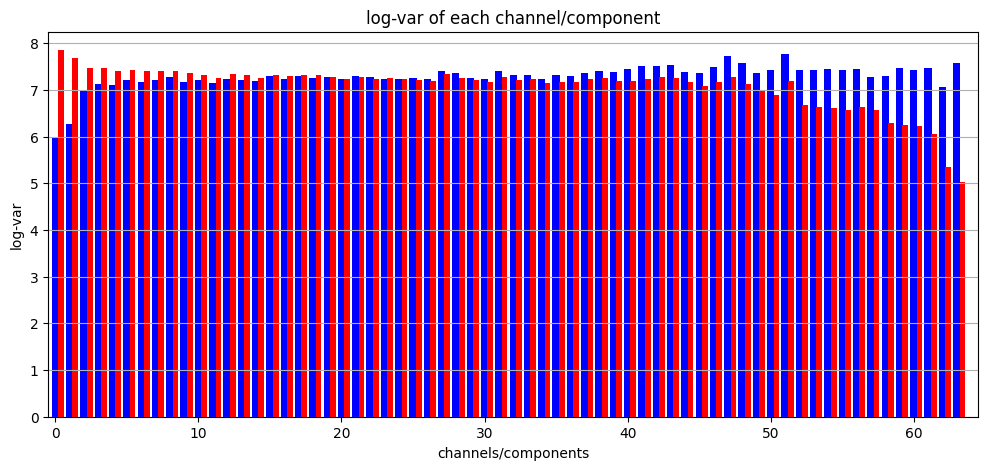

In [29]:
trials_logvar = {cl1: logvar(trials_csp[cl1].T),
                 cl2: logvar(trials_csp[cl2]).T}
plot_logvar(trials_logvar)

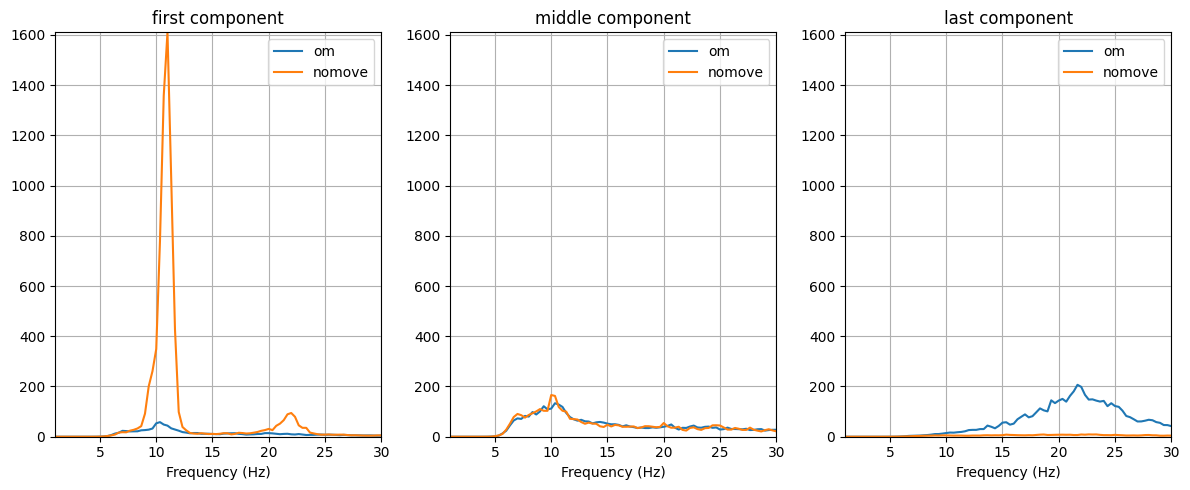

In [291]:
psd_r, freqs = psd(trials_csp[cl1].T)
psd_f, freqs = psd(trials_csp[cl2].T)
trials_PSD = {cl1: psd_r, cl2: psd_f}

plot_psd(trials_PSD, freqs, [0,28,-1], chan_lab=['first component', 'middle component', 'last component'], maxy=1610)

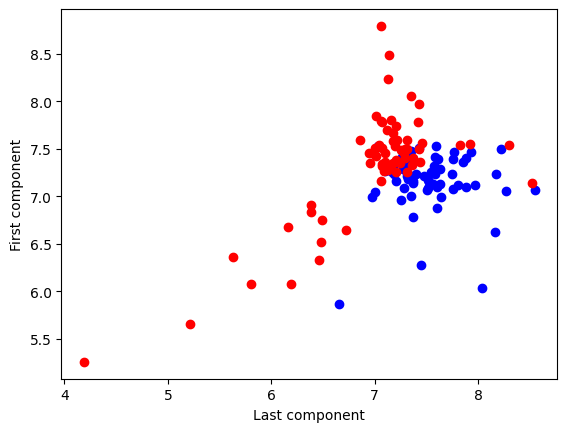

In [292]:
plot_scatter(trials_logvar[cl1], trials_logvar[cl2])

# features and classification

In [605]:
diff_ind_f = [ 9, 10, 11, 20, 21, 22]

In [606]:
feature_1 = np.mean(fft_res_1[diff_ind_f, :, :], axis=0)
feature_2 = np.mean(fft_res_2[diff_ind_f, :, :], axis=0)

In [607]:
def define_features(features, fft_t, epochs_ind):
    ind = (fft_t * 1000).astype(int)
    fft_t_ind = [np.where(np.isin(ind, X))[0] for X in epochs_ind]
    feature = np.array([np.mean(features[:, x], axis=1) for x in fft_t_ind])
    return feature

In [608]:
feat1 = define_features(feature_1, fft_t_1, epochs_ind_1)
feat2 = define_features(feature_2, fft_t_2, epochs_ind_2)

# classifier

In [614]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [609]:
X = np.concatenate([feat1, feat2], axis=0)
y = np.concatenate([np.ones(len(feat1)), np.zeros(len(feat2))])

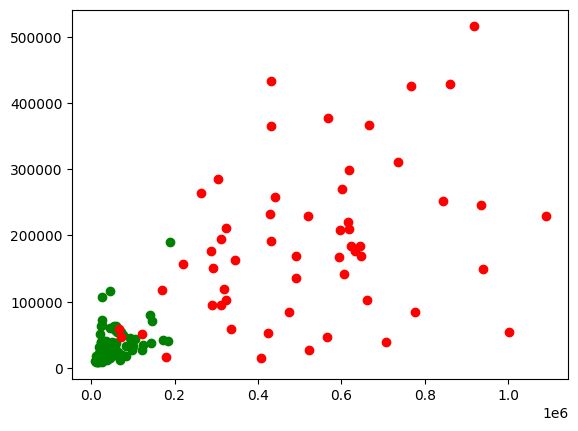

In [610]:
plt.scatter(feat1[:, 0], feat1[:, 1], color='green')
plt.scatter(feat2[:, 0], feat2[:, 1], color='red')

In [624]:
lda = LDA()
scores = cross_validate(lda, X, y, cv=5, scoring=('accuracy', 'f1'), return_train_score=True)

In [625]:
scores

{'fit_time': array([0.01711559, 0.00834703, 0.00831079, 0.00810122, 0.00800943]),
 'score_time': array([0.00107145, 0.00851822, 0.        , 0.00819349, 0.00800037]),
 'test_accuracy': array([0.90625   , 1.        , 1.        , 1.        , 0.96774194]),
 'train_accuracy': array([1., 1., 1., 1., 1.]),
 'test_f1': array([0.92307692, 1.        , 1.        , 1.        , 0.97560976]),
 'train_f1': array([1., 1., 1., 1., 1.])}

# test different covariance functions

In [59]:
epochs_1[:10000, :3]
changed_epochs_1 = copy.deepcopy(epochs_1)
changed_epochs_1[5000, 1] = 1

In [96]:
MCD = MinCovDet()
c1= MCD.fit(epochs_1[:10000, :3])

In [101]:
n_samples = 300000
n_features = 64
(n_samples + n_features + 1) / 2 / n_samples

0.5001083333333334

In [94]:
n = []
for fr in np.arange(0.1, 1.1, 0.1):
    MCD = MinCovDet(support_fraction=fr)
    c1= MCD.fit(epochs_1[:10000, :3])
    n.append(np.sum(c1.support_))

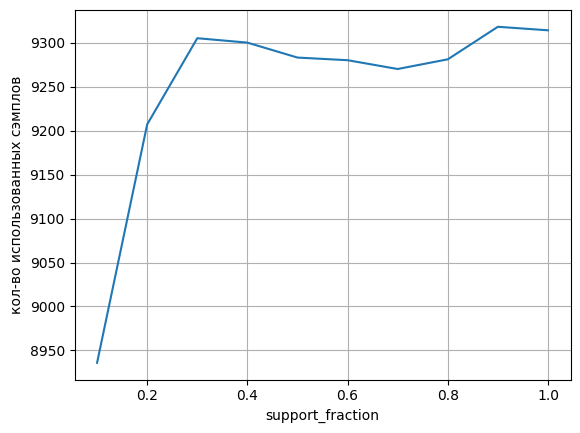

In [95]:
plt.plot(np.arange(0.1, 1.1, 0.1), n)
plt.xlabel('support_fraction')
plt.ylabel('кол-во использованных сэмплов')
plt.grid()

In [78]:
MCD = MinCovDet(support_fraction=0.5)
c1= MCD.fit(epochs_1[:10000, :3]*(10**6))

In [636]:
c1

array([[74.68273519, 41.5369154 , 41.5793567 , ...,  9.55389904,
        23.09848019, 29.13839089],
       [41.5369154 , 61.09510217, 44.47242627, ..., 11.9329033 ,
        26.13444679, 33.27283366],
       [41.5793567 , 44.47242627, 50.19069759, ..., 10.77498914,
        25.92314582, 34.15711232],
       ...,
       [ 9.55389904, 11.9329033 , 10.77498914, ..., 18.8905384 ,
        16.10606764, 15.12236121],
       [23.09848019, 26.13444679, 25.92314582, ..., 16.10606764,
        31.8035641 , 33.97553925],
       [29.13839089, 33.27283366, 34.15711232, ..., 15.12236121,
        33.97553925, 45.20289551]])

In [61]:
MCD = MinCovDet(support_fraction=1)
c1_changed= MCD.fit(changed_epochs_1[:10000, :3])

In [48]:
c1.covariance_

array([[5.37453351e-11, 3.26623629e-11, 3.36088110e-11],
       [3.26623629e-11, 4.04228739e-11, 3.89811126e-11],
       [3.36088110e-11, 3.89811126e-11, 4.72396452e-11]])

In [62]:
cov = np.cov(epochs_1[:10000, :3].T)
cov_changed = np.cov(changed_epochs_1[:10000, :3].T)

<Axes: >

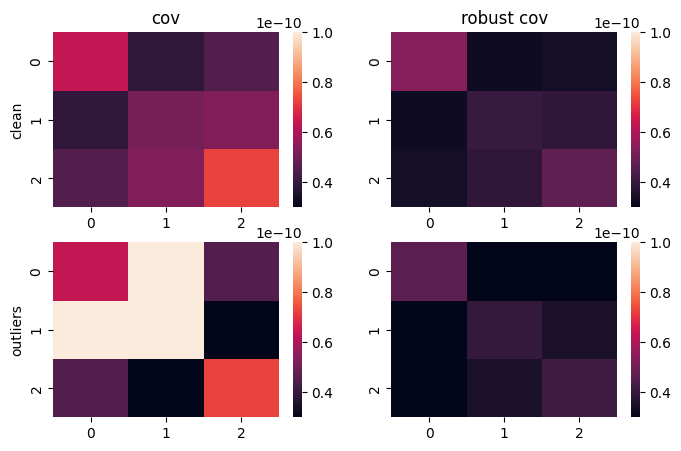

In [73]:
plt.figure(figsize=(8, 5))
plt.subplot(2, 2, 1)
sns.heatmap(cov, vmin=3*10**(-11), vmax=10*10**(-11))
plt.ylabel('clean')
plt.title('cov')
plt.subplot(2, 2, 2)
sns.heatmap(c1.covariance_, vmin=3*10**(-11), vmax=10*10**(-11))
plt.title('robust cov')
plt.subplot(2, 2, 3)
sns.heatmap(cov_changed, vmin=3*10**(-11), vmax=10*10**(-11))
plt.ylabel('outliers')
plt.subplot(2, 2, 4)
sns.heatmap(c1_changed.covariance_, vmin=3*10**(-11), vmax=10*10**(-11))

# mne 

In [244]:
ch_names = ['Ch' + str(i + 1) for i in range(eeg_1[:, :].shape[1])]
ch_types = ['eeg' for i in range(eeg_1[:, :].shape[1])]
sfreq = 1000
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

raw_1 = mne.io.RawArray(eeg_1.T, info)
raw_2 = mne.io.RawArray(eeg_2.T, info)

Creating RawArray with float64 data, n_channels=65, n_times=505320
    Range : 0 ... 505319 =      0.000 ...   505.319 secs
Ready.
Creating RawArray with float64 data, n_channels=65, n_times=352124
    Range : 0 ... 352123 =      0.000 ...   352.123 secs
Ready.


In [247]:
raw_1.filter(l_freq=6.0, h_freq=35.0, picks=ch_names[:-1], method='iir')
raw_2.filter(l_freq=6.0, h_freq=35.0, picks=ch_names[:-1], method='iir')

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 35.00 Hz: -6.02, -6.02 dB

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 6.00, 35.00 Hz: -6.02, -6.02 dB



Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,65 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.00 Hz
Lowpass,500.00 Hz


In [258]:
events_1 = mne.find_events(raw_1, 'Ch65', output='onset')
epochs_1 = mne.Epochs(raw_1, events_1, tmin=-2.999, tmax=0, picks=ch_names[:-1])
events_2 = mne.find_events(raw_2, 'Ch65', output='onset')
epochs_2 = mne.Epochs(raw_2, events_2, tmin=-2.999, tmax=0, picks=ch_names[:-1])

100 events found on stim channel Ch65
Event IDs: [1]
Not setting metadata
100 matching events found
Setting baseline interval to [-2.999, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Trigger channel Ch65 has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
56 events found on stim channel Ch65
Event IDs: [1]
Not setting metadata
56 matching events found
Setting baseline interval to [-2.999, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [299]:
events_1

array([[ 19142,      0,      1],
       [ 23259,      0,      1],
       [ 26360,      0,      1],
       [ 30910,      0,      1],
       [ 34728,      0,      1],
       [ 39395,      0,      1],
       [ 43513,      0,      1],
       [ 49547,      0,      1],
       [ 53648,      0,      1],
       [ 57949,      0,      1],
       [ 61749,      0,      1],
       [ 66834,      0,      1],
       [ 72035,      0,      1],
       [ 77302,      0,      1],
       [ 82153,      0,      1],
       [ 87788,      0,      1],
       [ 93022,      0,      1],
       [ 97523,      0,      1],
       [101807,      0,      1],
       [105941,      0,      1],
       [110809,      0,      1],
       [115293,      0,      1],
       [119810,      0,      1],
       [124394,      0,      1],
       [129595,      0,      1],
       [133413,      0,      1],
       [142031,      0,      1],
       [146532,      0,      1],
       [150733,      0,      1],
       [155300,      0,      1],
       [15

In [259]:
ep1_data = epochs_1.get_data()
ep2_data = epochs_2.get_data()
epochs = np.concatenate([ep1_data, ep2_data], axis=0)
labels= np.concatenate([np.ones(len(ep1_data)), np.zeros(len(ep2_data))], axis=0)

Using data from preloaded Raw for 100 events and 3000 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 56 events and 3000 original time points ...
0 bad epochs dropped


In [260]:
csp = CSP(n_components=2, transform_into='csp_space', reg=None)
csp_epochs = csp.fit_transform(epochs, labels)

Computing rank from data with rank=None


    Using tolerance 0.00032 (2.2e-16 eps * 64 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00036 (2.2e-16 eps * 64 dim * 2.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


In [280]:
eeg_raw_1 = raw_1.get_data(picks=ch_names[:-1]).T
eeg_raw_2 = raw_2.get_data(picks=ch_names[:-1]).T

eeg_csp_1 = csp.transform(eeg_raw_1)
eeg_csp_2 = csp.transform(eeg_raw_2)

## some check

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [5]:
filename = r"C:\Users\hodor\Documents\Eyes\eyelink_data\quasitest2\eeg\om1.hdf"
with h5py.File(filename, 'r') as h5f:
    eeg = h5f['eeg/data'][:]

(10405,)


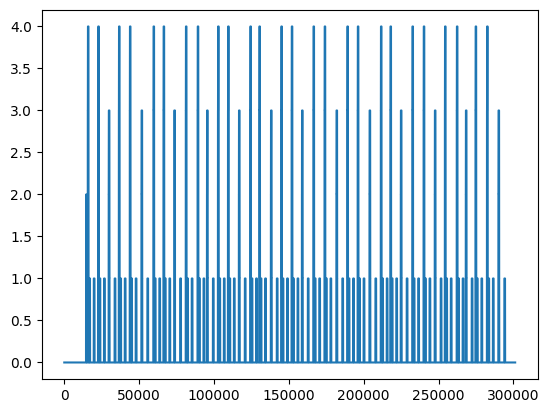

In [26]:
trigger = eeg[:-1, -1]
dtrigger = np.abs(np.diff(trigger))
wind_width = 500
avg_wind = []
for i in range(len(dtrigger)-wind_width):
    curr_dtr = dtrigger[i:i+wind_width]
    avg_wind.append(np.sum(curr_dtr))
avg_wind = np.array(avg_wind)
ind = np.where(avg_wind == 4.)[0]
print(np.where(avg_wind == 4.)[0].shape)
plt.plot(avg_wind)

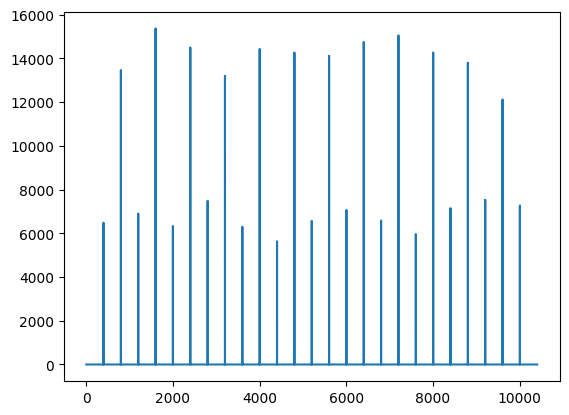

In [31]:
plt.plot(np.diff(ind))

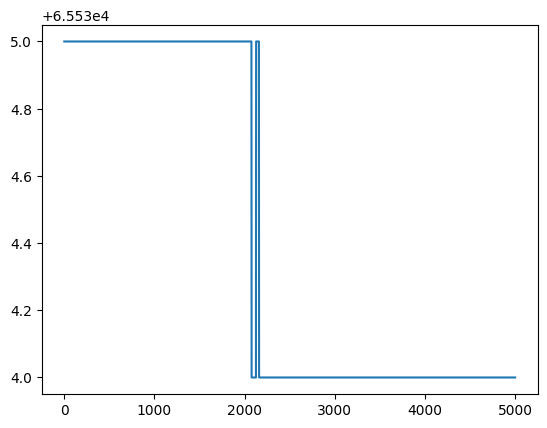

In [14]:
plt.plot(eeg[115000:120000, -1])

# standard way

In [289]:
# 3) FFT (длина окно, оконная функция, перекрытие)

SFT = ShortTimeFFT(win=p.fft_window, hop=1000-int(p.fft_overlap), fs=1000,  fft_mode='onesided' )
 
fft_res_1 = np.abs(SFT.stft(eeg_csp_1, axis=0)) ** 2
fft_res_2 = np.abs(SFT.stft(eeg_csp_2, axis=0)) ** 2

In [290]:
fft_res_1.shape

(501, 2, 5063)

In [276]:
# 4) Вычисление фич - пар канал+частота - из параметров: (канал, частоты, если несколько, то усредняются)
diff_ind_f = (p.features['freq'][0]).astype(int)-1
diff_ind_f

array([ 9, 10, 11, 20, 21, 22])

In [291]:
fft_t_1 = SFT.t(len(eeg_1))
fft_t_2 = SFT.t(len(eeg_2))

In [292]:
feature_1 = np.mean(fft_res_1[diff_ind_f, :, :], axis=0)
feature_2 = np.mean(fft_res_2[diff_ind_f, :, :], axis=0)
feature_1.shape, feature_2.shape

((2, 5063), (2, 3531))

In [215]:
def find_events(eeg): 
    photo_orig = eeg[:, -1]

    photo = np.zeros(len(photo_orig))
    photo[np.where(photo_orig == np.min(photo_orig))] = 1
    photo = photo.astype(int)

    return np.where(np.diff(photo) == 1)[0]

events_ind_1 = find_events(eeg_1)
events_ind_2 = find_events(eeg_2)

epoch_width = 3000
epochs_ind_1 = events_ind_1.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind_1), 1)) 
epochs_ind_2 = events_ind_2.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind_2), 1))
ind1 = (fft_t_1 * 1000).astype(int)
ind2 = (fft_t_2 * 1000).astype(int)

fft_t_ind1 = [np.where(np.isin(ind1, X))[0] for X in epochs_ind_1]
fft_t_ind2 = [np.where(np.isin(ind2, X))[0] for X in epochs_ind_2]

In [216]:
feat1 = np.array([np.mean(feature_1[:, x], axis=1) for x in fft_t_ind1])
feat2 = np.array([np.mean(feature_2[:, x], axis=1) for x in fft_t_ind2])

In [298]:
feat2

array([[ 458.07945756, 2527.48796878],
       [1399.03432585, 2711.04810464],
       [1266.9342841 , 2183.6137798 ],
       [1093.17155436, 2401.88289068],
       [1304.42270381, 1916.29080418],
       [ 768.61499016, 2488.11865851],
       [1765.7614013 , 1940.79465807],
       [1955.14701123, 1481.33346573],
       [1936.68012118, 2195.6036085 ],
       [1460.49530286, 2045.71542298],
       [1285.18304675, 4421.33523803],
       [1637.96132531, 2231.59632085],
       [1182.21752426, 2584.95673673],
       [1115.28628675, 2383.48042258],
       [1805.45266095, 2164.94156879],
       [1366.76028563, 2091.38496077],
       [2057.74833011, 2554.53814821],
       [ 845.56154768, 2086.1614515 ],
       [ 822.27318684, 1853.56219022],
       [1397.0649125 , 1801.23302507],
       [1012.82791103, 2213.0988766 ],
       [1126.24216029, 3567.6035569 ],
       [ 944.11923635, 2966.24915456],
       [ 842.07284862, 2328.44647379],
       [1623.10193043, 4170.85887556],
       [1373.24880654, 20

In [295]:
# 7) Классификатор LDA
scores_1 = feat1 @ p.LDAW + p.LDA_Const
scores_2 = feat2 @ p.LDAW + p.LDA_Const

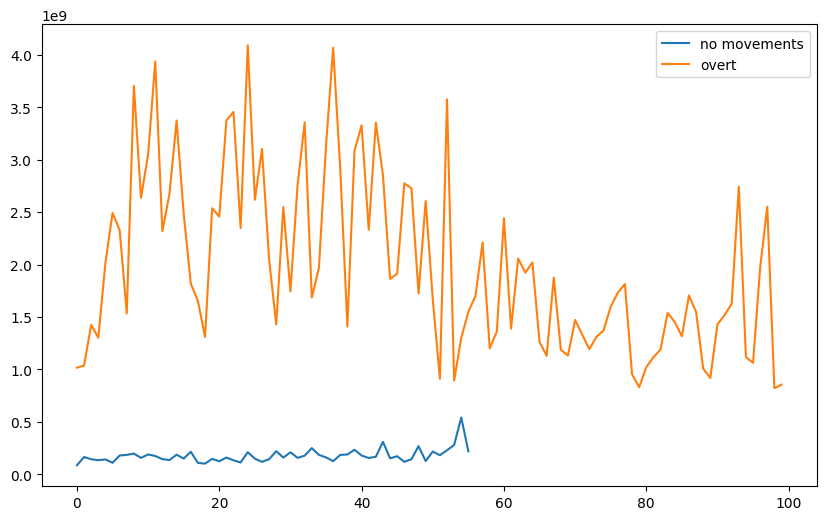

In [296]:
plt.figure(figsize=(10, 6))
plt.plot(scores_2, label='no movements')
plt.plot(scores_1, label='overt')
plt.legend()

In [215]:
# частотный фильтр
sos = butter(N=4, Wn=(6, 35), btype='bandpass', output='sos', fs=1000)
eeg_f1 = sosfiltfilt(np.ascontiguousarray(sos), eeg_1[:, :-1], axis=0)
eeg_f2 = sosfiltfilt(np.ascontiguousarray(sos), eeg_2[:, :-1], axis=0)

In [216]:
# эпохи
def get_epochs(eeg, trigger):
    events_ind = np.where(np.diff(trigger) == 1)[0]
    epoch_width = 3000
    epochs_ind = events_ind.reshape(-1, 1) + np.tile(np.arange(-epoch_width+1, 1), (len(events_ind), 1)) 
    epochs = np.array([eeg[x].T for x in epochs_ind])
    return epochs

epochs_1 = get_epochs(eeg_f1, eeg_1[:, -1])
epochs_2 = get_epochs(eeg_f2, eeg_2[:, -1])

c:\Users\hodor\Documents\Quasi\quasi-clf\.venv\Lib\site-packages\sklearn\covariance\_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


ValueError: The covariance matrix of the support data is equal to 0, try to increase support_fraction

In [243]:
epochs_1[0].T.shape

(3000, 64)

In [235]:
epochs_1.shape

(100, 64, 3000)

In [233]:
epochs_1.shape

(100, 64, 3000)

In [161]:
ch_names = ['Ch' + str(i + 1) for i in range(eeg_1[:, :].shape[1])]
ch_types = ['eeg' for i in range(eeg_1[:, :].shape[1])]
sfreq = 1000
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)

raw_1 = mne.io.RawArray(eeg_1.T, info)
raw_2 = mne.io.RawArray(eeg_2.T, info)

Creating RawArray with float64 data, n_channels=65, n_times=505320
    Range : 0 ... 505319 =      0.000 ...   505.319 secs
Ready.
Creating RawArray with float64 data, n_channels=65, n_times=352124
    Range : 0 ... 352123 =      0.000 ...   352.123 secs
Ready.


In [175]:
events_1 = mne.find_events(raw_1, 'Ch65', output='onset')
epochs_1 = mne.Epochs(raw_1, events_1, tmin=-2.999, tmax=0)

Trigger channel Ch65 has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
100 events found on stim channel Ch65
Event IDs: [1]
Not setting metadata
100 matching events found
Setting baseline interval to [-2.999, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [184]:
events_2 = mne.find_events(raw_2, 'Ch65', output='onset')
epochs_2 = mne.Epochs(raw_2, events_2, tmin=-2.999, tmax=0)

56 events found on stim channel Ch65
Event IDs: [1]
Not setting metadata
56 matching events found
Setting baseline interval to [-2.999, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [185]:
c1 = mne.compute_covariance(epochs_1, method='oas', n_jobs=-1)

Using data from preloaded Raw for 100 events and 3000 original time points ...
Computing rank from data with rank=None
    Using tolerance 1.5e-06 (2.2e-16 eps * 65 dim * 1e+08  max singular value)
    Estimated rank (eeg): 65
    EEG: rank 65 computed from 65 data channels with 0 projectors
Reducing data rank from 65 -> 65
Estimating covariance using OAS
Done.
Number of samples used : 300000
[done]


In [223]:
c1

<Covariance | kind : full, shape : (65, 65), range : [-5.4e-09, +0.036], n_samples : 299999>

In [186]:
ep1_data = epochs_1.get_data(picks=ch_names[:-1])
ep2_data = epochs_2.get_data(picks=ch_names[:-1])
epochs = np.concatenate([ep1_data, ep2_data], axis=0)
y = np.concatenate([np.ones(len(ep1_data)), np.zeros(len(ep2_data))], axis=0)
csp_filter = CSP(n_components=2, transform_into='csp_space', reg='oas')
csp_epochs = csp_filter.fit_transform(epochs, y)

Using data from preloaded Raw for 100 events and 3000 original time points ...
Using data from preloaded Raw for 56 events and 3000 original time points ...
0 bad epochs dropped


Computing rank from data with rank=None
    Using tolerance 0.00033 (2.2e-16 eps * 64 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 0.00039 (2.2e-16 eps * 64 dim * 2.8e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.


In [225]:
csp_filter.patterns_.shape

(64, 64)

In [207]:
eeg_f = np.concatenate([eeg_f1, eeg_f2], axis=0)

In [208]:
eeg_rearranged = csp_filter.transform(eeg_f)

In [212]:
eeg_rearranged

array([[-0.14017283,  0.30623511],
       [ 0.57604947,  0.37696866],
       [ 1.27822122,  0.43812589],
       ...,
       [-0.82383355,  0.19002889],
       [-0.47551017,  0.06239231],
       [-0.13714978, -0.06410611]])

In [213]:
eeg_rearranged_1

array([[ 0.03535879, -0.14492131],
       [ 0.03546649, -0.144912  ],
       [ 0.03554811, -0.14484943],
       ...,
       [ 0.03246687, -0.12724638],
       [ 0.03243589, -0.12726685],
       [ 0.0324353 , -0.12725136]])

In [120]:
epochs_ind_1

array([[ 16142,  16143,  16144, ...,  19139,  19140,  19141],
       [ 20259,  20260,  20261, ...,  23256,  23257,  23258],
       [ 23360,  23361,  23362, ...,  26357,  26358,  26359],
       ...,
       [479261, 479262, 479263, ..., 482258, 482259, 482260],
       [483928, 483929, 483930, ..., 486925, 486926, 486927],
       [494197, 494198, 494199, ..., 497194, 497195, 497196]], dtype=int64)

In [35]:
epochs = np.concatenate([epochs_1, epochs_2], axis=0)
y = np.concatenate([np.ones(len(epochs_1)), np.zeros(len(epochs_2))], axis=0)

TypeError: compute_covariance() got an unexpected keyword argument 'outlier_frac'

In [65]:
csp_filter = CSP(n_components=2, transform_into='csp_space')
csp_epochs = csp_filter.fit_transform(epochs, y)

Computing rank from data with rank=None
    Using tolerance 0.00033 (2.2e-16 eps * 64 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00038 (2.2e-16 eps * 64 dim * 2.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.


In [54]:
csp_epochs.shape

(156, 2, 3000)

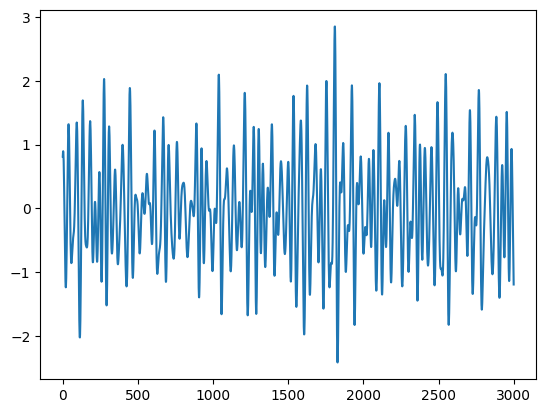

In [76]:
plt.plot(csp_epochs[0][0])

In [77]:
MatParameters = namedtuple(
    "MatParameters",
    "eeg_chans_inds which_photo photo_chan_ind photo_analog_parameters spatialW fft_length fft_overlap fft_window features features_window features_average LDAW LDA_Const b a sos",
)

def load_parameters_from_mat(mat: str) -> MatParameters:
    mat = mat73.loadmat(mat)
    return MatParameters(**{f: mat.get(f, None) for f in MatParameters._fields})

mat = r'..\data\from_matlab\classifier_test_orig.mat'
p = load_parameters_from_mat(mat)

In [78]:
eeg_rearranged_1 = eeg_1[:, :-1] @ p.spatialW # overtmove
eeg_rearranged_2 = eeg_2[:, :-1] @ p.spatialW # nomove

# 2) Фильтрация (вгружаемые коэффициенты: [b a] или [sos]
eeg_fil1 = sosfiltfilt(np.ascontiguousarray(p.sos), eeg_rearranged_1, axis=0)
eeg_fil2 = sosfiltfilt(np.ascontiguousarray(p.sos), eeg_rearranged_2, axis=0)

In [80]:
epochs_old_1 = np.array([eeg_fil1[x].T for x in epochs_ind_1])
epochs_old_2 = np.array([eeg_fil2[x].T for x in epochs_ind_2])

In [81]:
epochs_old_1.shape

(100, 2, 3000)

In [93]:
epochs.shape

(156, 64, 3000)

In [90]:
csp_filter = CSP(n_components=2, transform_into='csp_space', reg=1, norm_trace=False)
csp_epochs = csp_filter.fit_transform(epochs, y)

Computing rank from data with rank=None


    Using tolerance 0.00033 (2.2e-16 eps * 64 dim * 2.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank=None
    Using tolerance 0.00038 (2.2e-16 eps * 64 dim * 2.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using SHRINKAGE
Done.


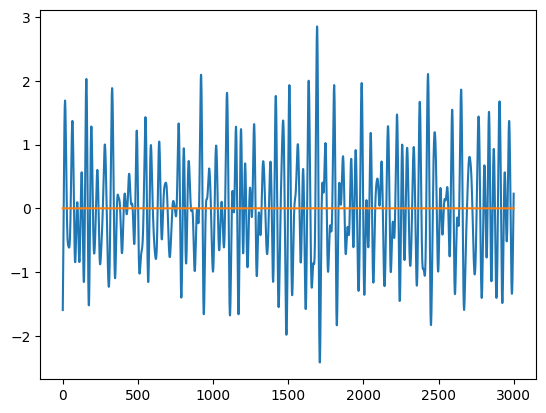

In [226]:
plt.plot(csp_epochs[0][0])
plt.plot(epochs_old_1[0][0])

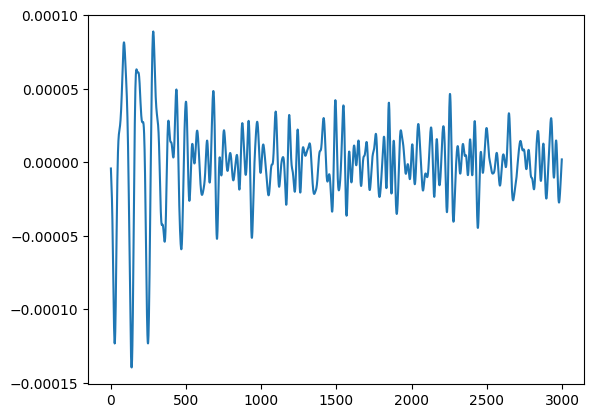

In [86]:
plt.plot(epochs_old_1[0][0])

In [197]:
# 3) FFT (длина окно, оконная функция, перекрытие)

SFT = ShortTimeFFT(win=p.fft_window, hop=1000-int(p.fft_overlap), fs=1000,  fft_mode='onesided' )

# fft_result_1 = SFT.spectrogram(eeg_f1, axis=0)
# fft_result_2 = SFT.spectrogram(eeg_f2, axis=0) 
fft_res_1 = np.abs(SFT.stft(csp_epochs, axis=0)) ** 2
fft_res_2 = np.abs(SFT.stft(csp_epochs, axis=0)) ** 2

ValueError: of axis=0 of (156, 2, 3000) must be >= ceil(m_num/2) = 500!

In [ ]:
fft_t_1 = SFT.t(len())
fft_t_2 = SFT.t(len(eeg_2))